In [1]:
import pandas as pd

# 获取所有符合模式的CSV文件
file_patterns = ['May_weather.csv', 'June_weather.csv', 'July_weather.csv', 'August_weather.csv']
# 或者使用通配符自动匹配：file_list = glob.glob('*_weather.csv')

# 创建一个空列表来存储各个数据帧
dfs = []

# 循环读取每个文件并添加到列表中
for file in file_patterns:
    df = pd.read_csv(file)
    dfs.append(df)

# 使用concat合并所有数据帧
df = pd.concat(dfs, ignore_index=True)



In [2]:
df.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DATE', 'MKT_AIRLINE',
       'MKT_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID',
       'ORIGIN_CITY_MARKET_ID', 'ORIGIN_IATA', 'ORIGIN_CITY',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID',
       'DEST_IATA', 'DEST_CITY', 'SCH_DEP_TIME', 'ACT_DEP_TIME', 'DEP_DELAY',
       'DEP_DELAY_NEW', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
       'SCH_ARR_TIME', 'ACT_ARR_TIME', 'ARR_DELAY', 'CANCELLED',
       'CANCELLATION_CODE', 'SCH_DURATION', 'ACT_DURATION', 'AIR_TIME',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'TOTAL_ADD_GTIME', 'WEEK',
       'ORIGIN_TYPE', 'ORIGIN_ELEV', 'ORIGIN_TZ', 'DEST_TYPE', 'DEST_ELEV',
       'DEST_TZ', 'SCH_DEP_TIME_UTC', 'ACT_DEP_TIME_UTC', 'SCH_ARR_TIME_UTC',
       'ACT_ARR_TIME_UTC', 'Count_x', 'Latitude_origin', 'Longitude_origin',
       'Altitude_x', 'daylight_saving_offset_x', 'standard_offset_x',

In [3]:
# 按星期分组，计算取消率和总航班数
cancellation_stats = df.groupby("DAY_OF_WEEK")["CANCELLED"].agg(
    total_flights="count",
    cancelled_flights="sum"
).reset_index()

cancellation_stats["cancellation_rate"] = (
    cancellation_stats["cancelled_flights"] / cancellation_stats["total_flights"]
)

In [4]:
# 仅保留未取消的航班，计算平均延误
departure_delay = df[df["CANCELLED"] == 0].groupby("DAY_OF_WEEK")["DEP_DELAY"].mean().reset_index()
departure_delay.rename(columns={"DEP_DELAY": "avg_departure_delay"}, inplace=True)

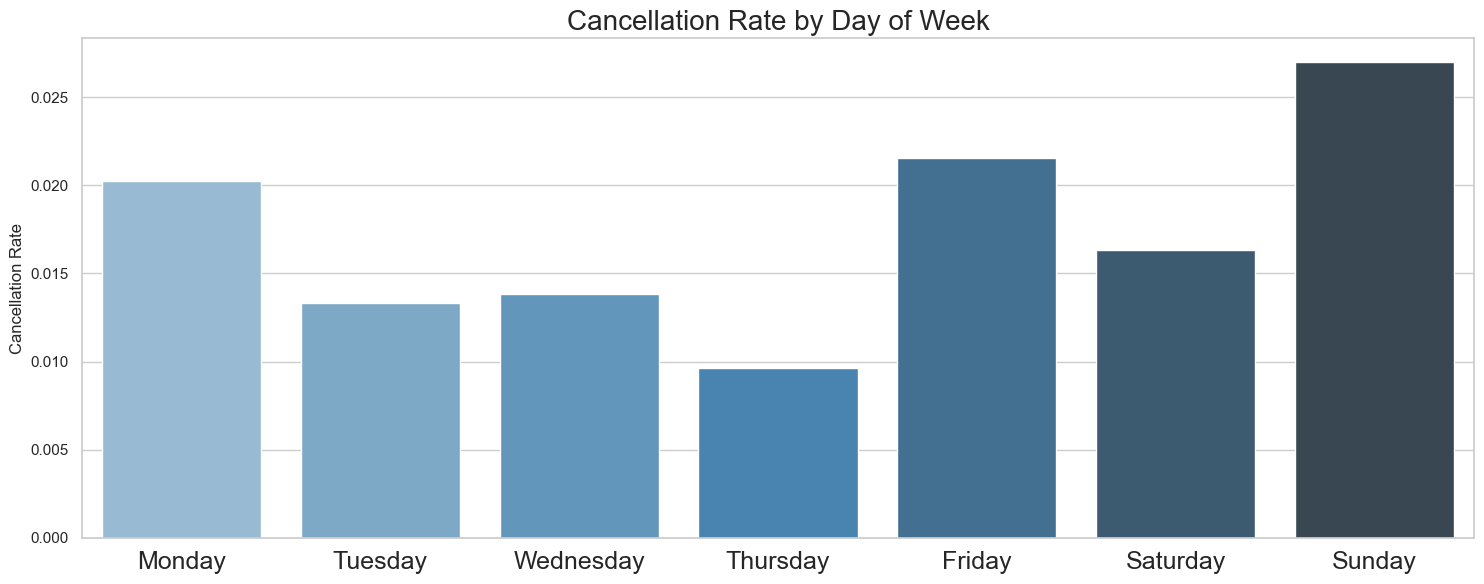

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置画布和主题
plt.figure(figsize=(15, 6))
sns.set_theme(style="whitegrid")

# 将星期数字映射为名称
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# --- 子图1：取消率 ---
plt.subplot(1, 1, 1)
sns.barplot(
    data=cancellation_stats,
    x="DAY_OF_WEEK",
    y="cancellation_rate",
    palette="Blues_d"
)
plt.title("Cancellation Rate by Day of Week", fontsize=20)
plt.xlabel("")
plt.ylabel("Cancellation Rate")
plt.xticks(ticks=range(7), labels=day_names, rotation=0, fontsize=18)

# # --- 子图2：平均起飞延误 ---
# plt.subplot(1, 2, 2)
# sns.barplot(
#     data=departure_delay,
#     x="DAY_OF_WEEK",
#     y="avg_departure_delay",
#     palette="Reds_d"
# )
# plt.title("Average Departure Delay by Day of Week", fontsize=12)
# plt.xlabel("Day of Week")
# plt.ylabel("Average Delay (minutes)")
# plt.xticks(ticks=range(7), labels=day_names, rotation=45)

plt.tight_layout()
plt.show()

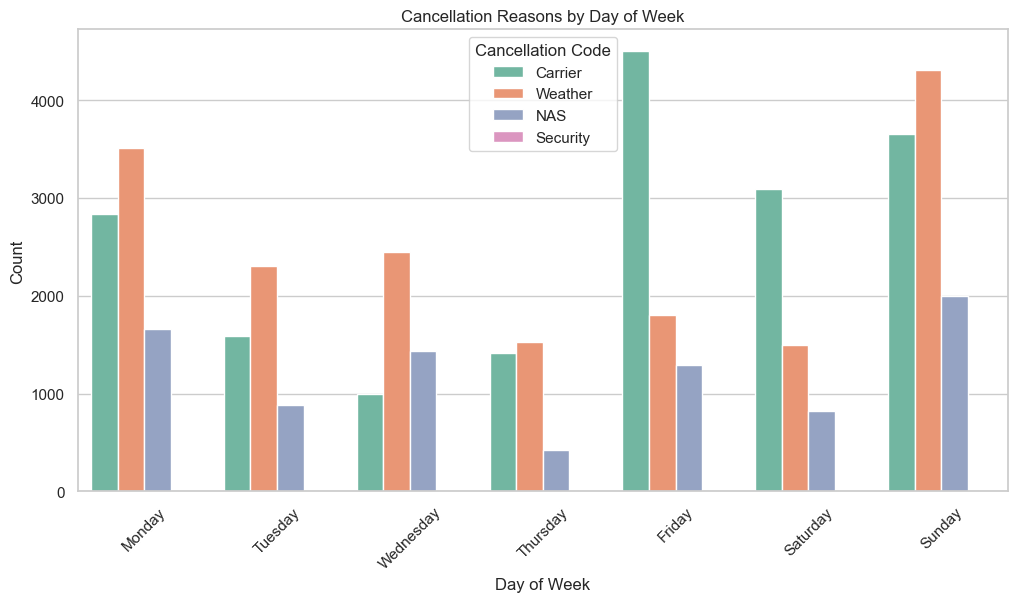

In [6]:
if "CANCELLATION_CODE" in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(
        data=df[df["CANCELLED"] == 1],
        x="DAY_OF_WEEK",
        hue="CANCELLATION_CODE",
        palette="Set2"
    )
    plt.title("Cancellation Reasons by Day of Week", fontsize=12)
    plt.xlabel("Day of Week")
    plt.ylabel("Count")
    plt.xticks(ticks=range(7), labels=day_names, rotation=45)
    plt.legend(title="Cancellation Code")
    plt.show()

In [7]:
# 定义天气相关列
weather_cols = [
    'origin_temperature_avg_C', 'origin_precipitation_mm', 'origin_wind_speed_kph', 'origin_snow_mm',
    'dest_temperature_avg_C', 'dest_precipitation_mm', 'dest_wind_speed_kph', 'dest_snow_mm'
]

# 提取天气数据和目标变量
weather_df = df[weather_cols + ['DEP_DELAY', 'ARR_DELAY', 'CANCELLED', 'WEATHER_DELAY']].copy()

In [8]:
# 检查天气数据缺失值
print(weather_df[weather_cols].isnull().sum())

# 删除或填充缺失值（示例：用中位数填充）
weather_df.fillna(weather_df.median(numeric_only=True), inplace=True)

origin_temperature_avg_C      7376
origin_precipitation_mm       7570
origin_wind_speed_kph         7321
origin_snow_mm              476587
dest_temperature_avg_C        7375
dest_precipitation_mm         7574
dest_wind_speed_kph           7319
dest_snow_mm                476623
dtype: int64


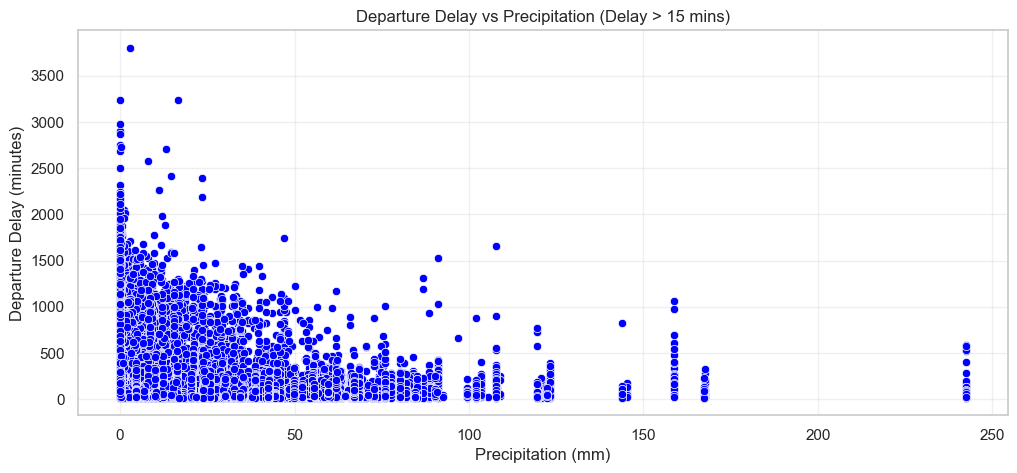

In [76]:
delay_threshold = 15
filtered_df = weather_df[weather_df['ARR_DELAY'] > delay_threshold]
plt.figure(figsize=(12, 5))
# 分面分析：按降水量分位点划分区间
precip_bins = [0, 0.1, 1, 5, 10, 20, 50, 100]
plt.scatter(
    x=filtered_df['dest_precipitation_mm'],
    y=filtered_df['ARR_DELAY'],
    color='blue',  # 固定颜色
    alpha=1,       # 固定不透明度
    edgecolors='w',
    linewidth=0.5
)


#plt.colorbar(label='Precipitation (mm)')
plt.title(f"Departure Delay vs Precipitation (Delay > {delay_threshold} mins)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Departure Delay (minutes)")
plt.grid(alpha=0.3)
plt.show()

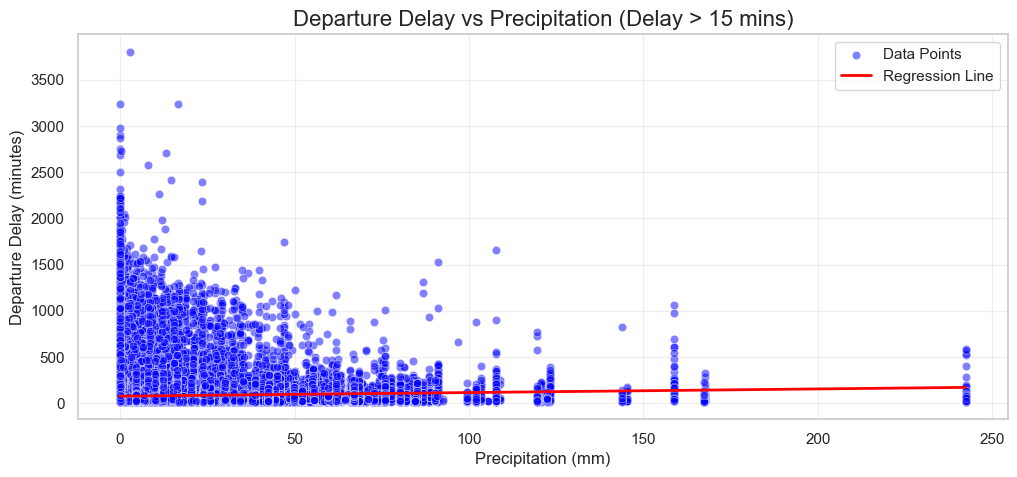

In [80]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

delay_threshold = 15
filtered_df = weather_df[weather_df['ARR_DELAY'] > delay_threshold]

plt.figure(figsize=(12, 5))

# 原始散点图
plt.scatter(
    x=filtered_df['dest_precipitation_mm'],
    y=filtered_df['ARR_DELAY'],
    color='blue',
    alpha=0.5,  # 轻微透明度便于观察重叠点
    edgecolors='w',
    linewidth=0.5,
    label='Data Points'
)

# 计算线性回归
slope, intercept, r_value, p_value, std_err = linregress(
    x=filtered_df['dest_precipitation_mm'],
    y=filtered_df['ARR_DELAY']
)

# 生成回归线数据
x_line = filtered_df['dest_precipitation_mm'].agg(['min', 'max'])
y_line = slope * x_line + intercept

# 绘制回归线
plt.plot(
    x_line,
    y_line,
    color='red',
    linewidth=2,
    label='Regression Line'
)

# 添加图例和标注
plt.title(f"Departure Delay vs Precipitation (Delay > {delay_threshold} mins)", fontsize=16)
plt.xlabel("Precipitation (mm)")
plt.ylabel("Departure Delay (minutes)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

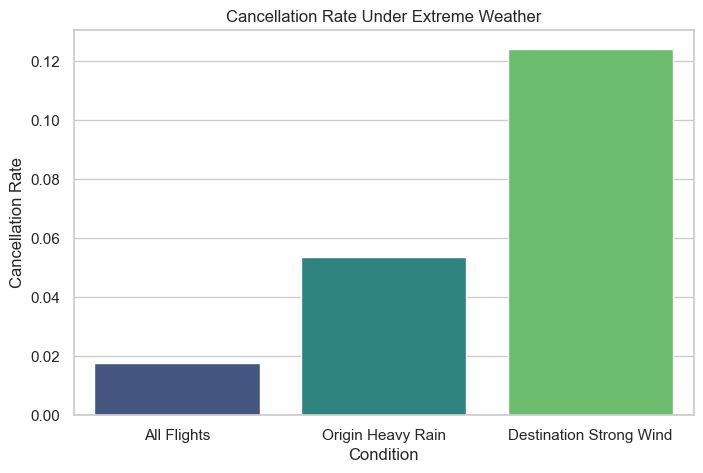

In [56]:
# 定义极端天气阈值（根据实际情况调整）
heavy_rain_threshold = 10  # 降水量 >=10mm 视为大雨
strong_wind_threshold = 30  # 风速 >=30kph 视为大风

# 标记极端天气事件
weather_df['origin_heavy_rain'] = (weather_df['origin_precipitation_mm'] >= heavy_rain_threshold).astype(int)
weather_df['dest_strong_wind'] = (weather_df['dest_wind_speed_kph'] >= strong_wind_threshold).astype(int)

# 计算极端天气下的取消率
cancellation_rates = pd.DataFrame({
    'Condition': ['All Flights', 'Origin Heavy Rain', 'Destination Strong Wind'],
    'Cancellation Rate': [
        weather_df['CANCELLED'].mean(),
        weather_df[weather_df['origin_heavy_rain'] == 1]['CANCELLED'].mean(),
        weather_df[weather_df['dest_strong_wind'] == 1]['CANCELLED'].mean()
    ]
})

# 绘制取消率对比
plt.figure(figsize=(8, 5))
sns.barplot(data=cancellation_rates, x='Condition', y='Cancellation Rate', palette='viridis')
plt.title("Cancellation Rate Under Extreme Weather")
plt.xticks(rotation=0)
plt.show()

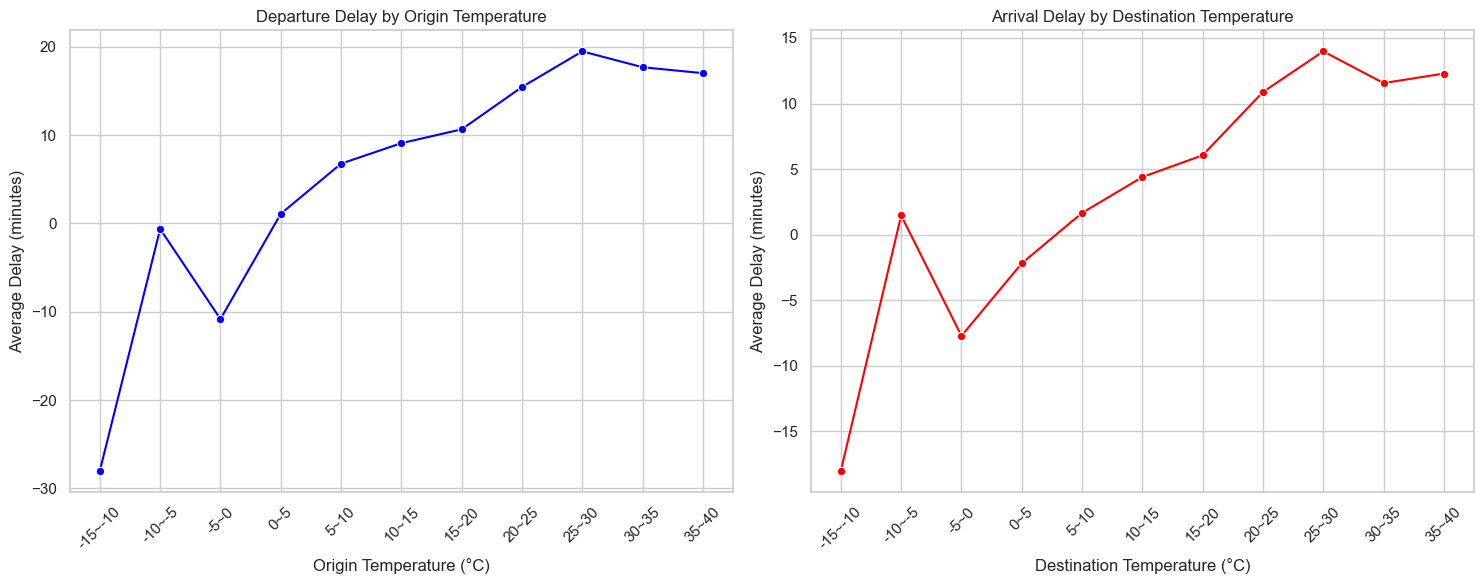

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置温度分箱（示例：-20°C 到 40°C，每5°C一个区间）
temp_bins = np.arange(-20, 45, 5)
temp_labels = [f"{i}~{i+5}" for i in temp_bins[:-1]]

# 分析出发地温度与起飞延误
weather_df['origin_temp_bin'] = pd.cut(
    weather_df['origin_temperature_avg_C'],
    bins=temp_bins,
    labels=temp_labels
)
origin_temp_delay = weather_df.groupby('origin_temp_bin')['DEP_DELAY'].mean().reset_index()

# 分析目的地温度与到达延误
weather_df['dest_temp_bin'] = pd.cut(
    weather_df['dest_temperature_avg_C'],
    bins=temp_bins,
    labels=temp_labels
)
dest_temp_delay = weather_df.groupby('dest_temp_bin')['ARR_DELAY'].mean().reset_index()

# 绘制温度与延误双图
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.lineplot(
    data=origin_temp_delay,
    x='origin_temp_bin',
    y='DEP_DELAY',
    marker='o',
    color='blue'
)
plt.title("Departure Delay by Origin Temperature")
plt.xlabel("Origin Temperature (°C)")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.lineplot(
    data=dest_temp_delay,
    x='dest_temp_bin',
    y='ARR_DELAY',
    marker='o',
    color='red'
)
plt.title("Arrival Delay by Destination Temperature")
plt.xlabel("Destination Temperature (°C)")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 定义函数将HHMM格式时间转换为小时段（0-23）
def convert_time_to_hour(time_series):
    # 处理缺失值（假设用0填充）
    time_series = time_series.fillna(0).astype(int)
    # 提取小时部分（例如：1430 -> 14小时）
    hours = (time_series // 100).clip(0, 23)  # 确保小时在0-23之间
    return hours

# 创建小时段列
df['departure_hour'] = convert_time_to_hour(df['SCH_DEP_TIME'])
df['arrival_hour'] = convert_time_to_hour(df['SCH_ARR_TIME'])

In [13]:
# 定义3小时时段的分组逻辑
def create_time_bins(hour_series):
    bins = [0, 3, 6, 9, 12, 15, 18, 21, 24]
    labels = [
        "0-2", "3-5", "6-8",
        "9-11", "12-14", "15-17",
        "18-20", "21-23"
    ]
    return pd.cut(hour_series, bins=bins, labels=labels, right=False)

# 应用分组
df['departure_3h'] = create_time_bins(df['departure_hour'])
df['arrival_3h'] = create_time_bins(df['arrival_hour'])

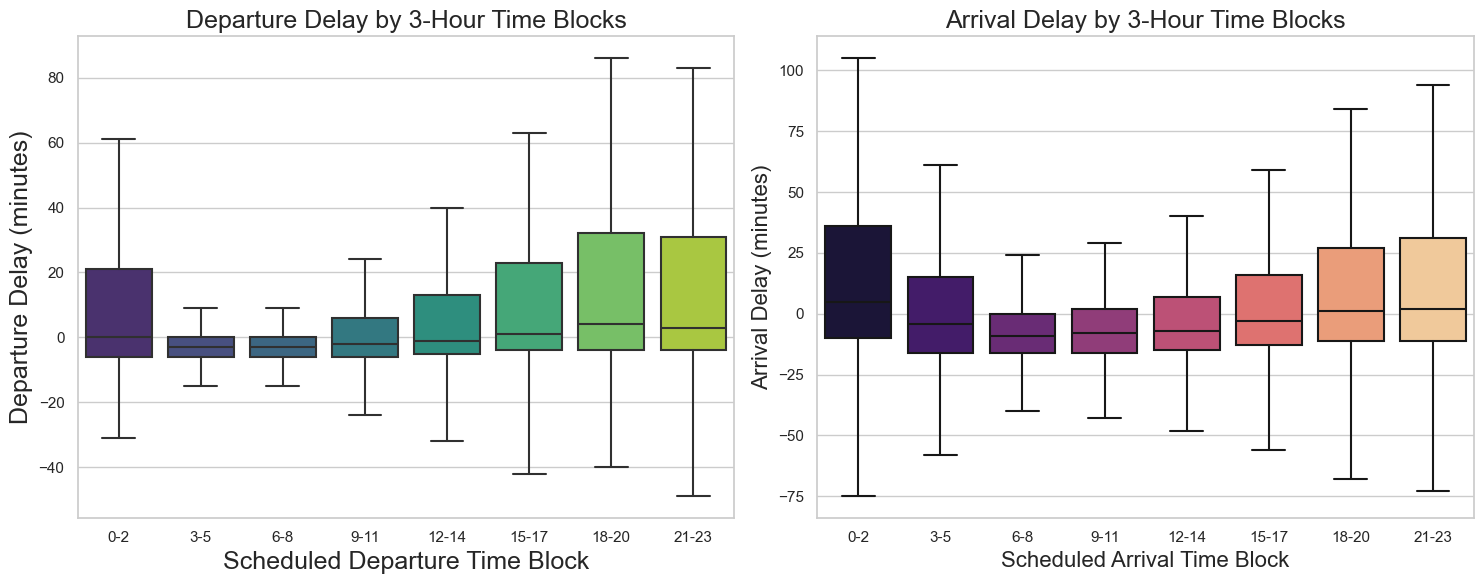

In [47]:
plt.figure(figsize=(15, 6))
labels = [
        "0-2", "3-5", "6-8",
        "9-11", "12-14", "15-17",
        "18-20", "21-23"
    ]
# 起飞时段延误分布
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df[df['CANCELLED'] == 0],
    x='departure_3h',
    y='DEP_DELAY',
    order=labels,  # 使用定义的labels保证顺序
    showfliers=False,
    palette='viridis'
)
plt.title("Departure Delay by 3-Hour Time Blocks", fontsize = 18)
plt.xlabel("Scheduled Departure Time Block", fontsize = 18)
plt.ylabel("Departure Delay (minutes)", fontsize = 18)

# 到达时段延误分布
plt.subplot(1, 2, 2)
sns.boxplot(
    data=df[df['CANCELLED'] == 0],
    x='arrival_3h',
    y='ARR_DELAY',
    order=labels,
    showfliers=False,
    palette='magma'
)
plt.title("Arrival Delay by 3-Hour Time Blocks", fontsize = 18)
plt.xlabel("Scheduled Arrival Time Block", fontsize = 16)
plt.ylabel("Arrival Delay (minutes)", fontsize = 16)

plt.tight_layout()
plt.show()

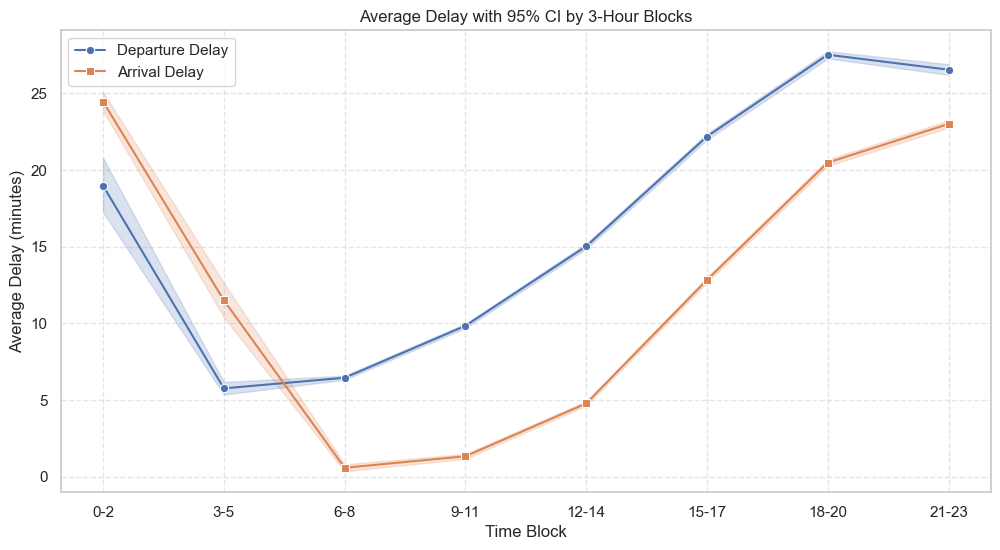

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df[df['CANCELLED'] == 0],
    x='departure_3h',
    y='DEP_DELAY',
    estimator='mean',
    errorbar=('ci', 95),  # 显示95%置信区间
    marker='o',
    label='Departure Delay'
)
sns.lineplot(
    data=df[df['CANCELLED'] == 0],
    x='arrival_3h',
    y='ARR_DELAY',
    estimator='mean',
    errorbar=('ci', 95),
    marker='s',
    label='Arrival Delay'
)
plt.title("Average Delay with 95% CI by 3-Hour Blocks")
plt.xlabel("Time Block")
plt.ylabel("Average Delay (minutes)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

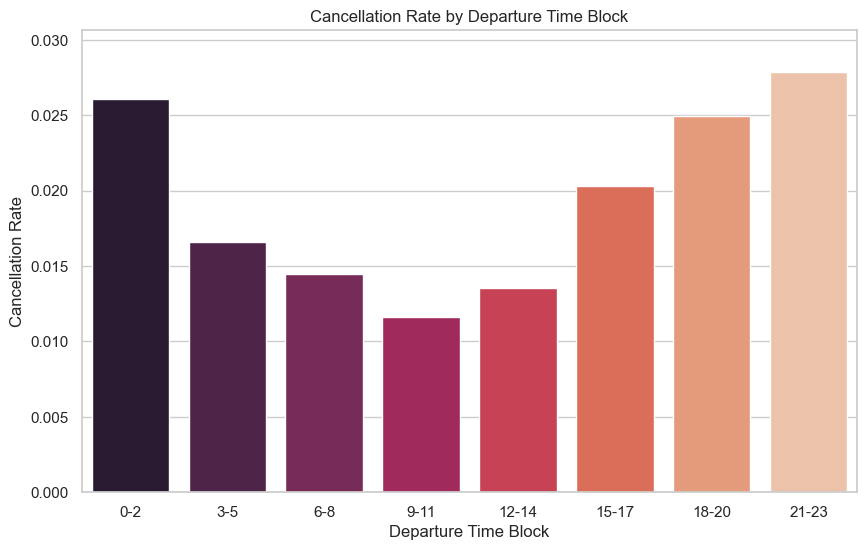

In [21]:
# 计算各时段取消率
cancel_by_departure = df.groupby('departure_3h')['CANCELLED'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=cancel_by_departure,
    x='departure_3h',
    y='CANCELLED',
    order=labels,
    palette='rocket'
)
plt.title("Cancellation Rate by Departure Time Block")
plt.xlabel("Departure Time Block")
plt.ylabel("Cancellation Rate")
plt.ylim(0, cancel_by_departure['CANCELLED'].max()*1.1)
plt.show()

In [ ]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# 创建美国联邦假日日历
holiday_cal = USFederalHolidayCalendar()
holidays = holiday_cal.holidays(start=df['DATE'].min(), end=df['DATE'].max())

# 转换为日期集合加速查询
us_holidays = set(holidays.date)

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE']).dt.date

# 标记是否为节假日
df['is_holiday'] = df['DATE'].isin(us_holidays).astype(int)  # 或使用custom_holidays

# 标记节假日前后的日期（例如节假日前后1天）
df['is_holiday_period'] = 0
for offset in [-1, 0, 1]:
    df['temp_date'] = df['DATE'] + pd.DateOffset(days=offset)
    df['is_holiday_period'] |= df['temp_date'].isin(us_holidays).astype(int)
df.drop(columns=['temp_date'], inplace=True)

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df[df['CANCELLED'] == 0],
    x='is_holiday',
    y='DEP_DELAY',
    showfliers=False,
    palette={0: 'skyblue', 1: 'salmon'}
)
plt.title("Departure Delay: Holiday vs Non-Holiday")
plt.xlabel("Is Holiday (0=No, 1=Yes)")
plt.ylabel("Delay (minutes)")
plt.xticks([0, 1], ["Non-Holiday", "Holiday"])
plt.show()

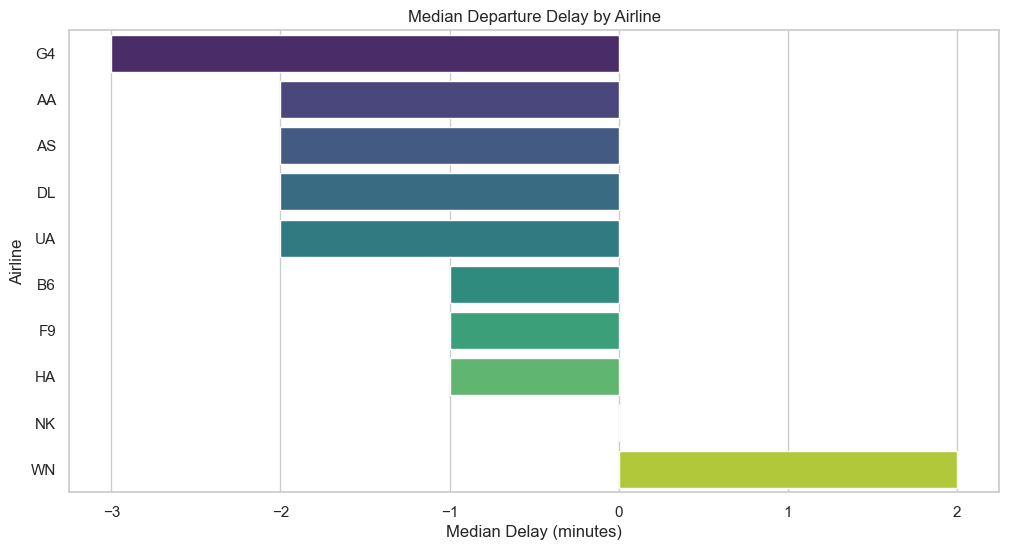

In [22]:
# 计算各航司延误中位数
airline_delay = df[df['CANCELLED'] == 0].groupby('MKT_AIRLINE')['DEP_DELAY'].median().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(
    x=airline_delay.values,
    y=airline_delay.index,
    palette='viridis'
)
plt.title("Median Departure Delay by Airline")
plt.xlabel("Median Delay (minutes)")
plt.ylabel("Airline")
plt.show()

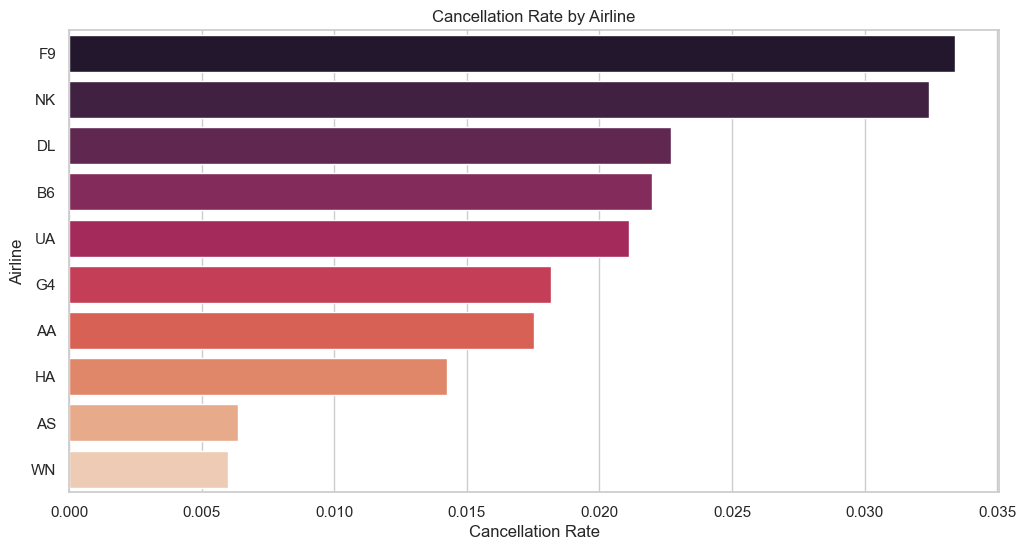

In [23]:
airline_cancel = df.groupby('MKT_AIRLINE')['CANCELLED'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    x=airline_cancel.values,
    y=airline_cancel.index,
    palette='rocket'
)
plt.title("Cancellation Rate by Airline")
plt.xlabel("Cancellation Rate")
plt.ylabel("Airline")
plt.show()

In [25]:
# 检查ORIGIN_TYPE的类别分布
print("机场类型分布:\n", df["ORIGIN_TYPE"].value_counts())

# 提取主要类型（可选：合并低频类型为"Other"）
main_types = ["large_airport", "medium_airport", "small_airport"]
df["origin_type_clean"] = df["ORIGIN_TYPE"].where(
    df["ORIGIN_TYPE"].isin(main_types), 
    other="Other"
)

机场类型分布:
 large_airport     2070313
medium_airport     437614
small_airport         939
Name: ORIGIN_TYPE, dtype: int64


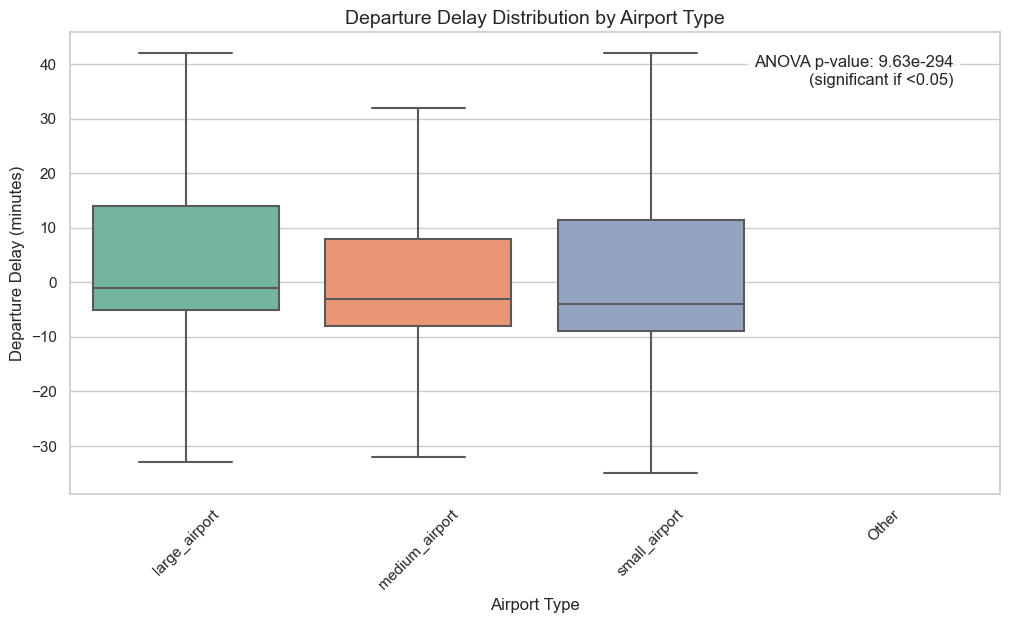

In [26]:
plt.figure(figsize=(12, 6))

# 箱线图配置
sns.boxplot(
    data=df[df["CANCELLED"] == 0],  # 仅未取消航班
    x="origin_type_clean",
    y="DEP_DELAY",
    order=main_types + ["Other"],  # 控制排序
    showfliers=False,  # 隐藏异常值
    palette="Set2"
)

# 添加统计注释（ANOVA检验结果）
from scipy.stats import f_oneway
groups = [df[(df["origin_type_clean"] == t) & (df["CANCELLED"] == 0)]["DEP_DELAY"] for t in main_types]
f_stat, p_value = f_oneway(*groups)
plt.text(
    0.95, 0.95, 
    f"ANOVA p-value: {p_value:.2e}\n(significant if <0.05)", 
    transform=plt.gca().transAxes,
    ha='right', va='top',
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.title("Departure Delay Distribution by Airport Type", fontsize=14)
plt.xlabel("Airport Type", fontsize=12)
plt.ylabel("Departure Delay (minutes)", fontsize=12)
plt.xticks(rotation=45)
plt.show()

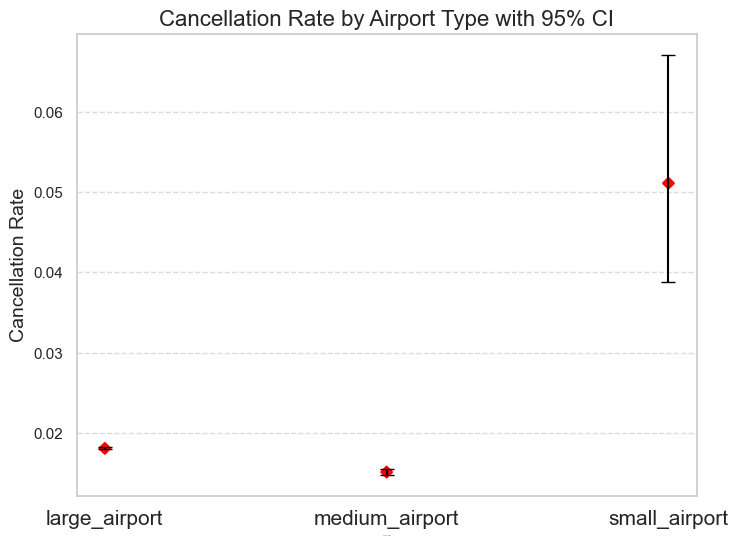

In [55]:
plt.figure(figsize=(8, 6))

# 计算取消率及置信区间
import numpy as np
from statsmodels.stats.proportion import proportion_confint

cancel_rates = df.groupby("origin_type_clean")["CANCELLED"].agg(
    rate=lambda x: np.mean(x),
    count=lambda x: len(x)
).reset_index()

# 计算95%置信区间
conf_intervals = [proportion_confint(row["count"]*row["rate"], row["count"], method='wilson')
                 for _, row in cancel_rates.iterrows()]
cancel_rates["lower"], cancel_rates["upper"] = zip(*conf_intervals)

# 绘制误差线图
sns.pointplot(
    data=cancel_rates,
    x="origin_type_clean",
    y="rate",
    order=main_types + ["Other"],
    join=False,
    color='red',
    markers='D',
    scale=0.8
)

# 添加置信区间
plt.errorbar(
    x=range(len(cancel_rates)),
    y=cancel_rates["rate"],
    yerr=[cancel_rates["rate"] - cancel_rates["lower"], cancel_rates["upper"] - cancel_rates["rate"]],
    fmt='none',
    ecolor='black',
    capsize=5
)

plt.title("Cancellation Rate by Airport Type with 95% CI", fontsize=16)
plt.xlabel("Airport Type", fontsize=0)
plt.ylabel("Cancellation Rate", fontsize=14)
plt.xticks(rotation=0, fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

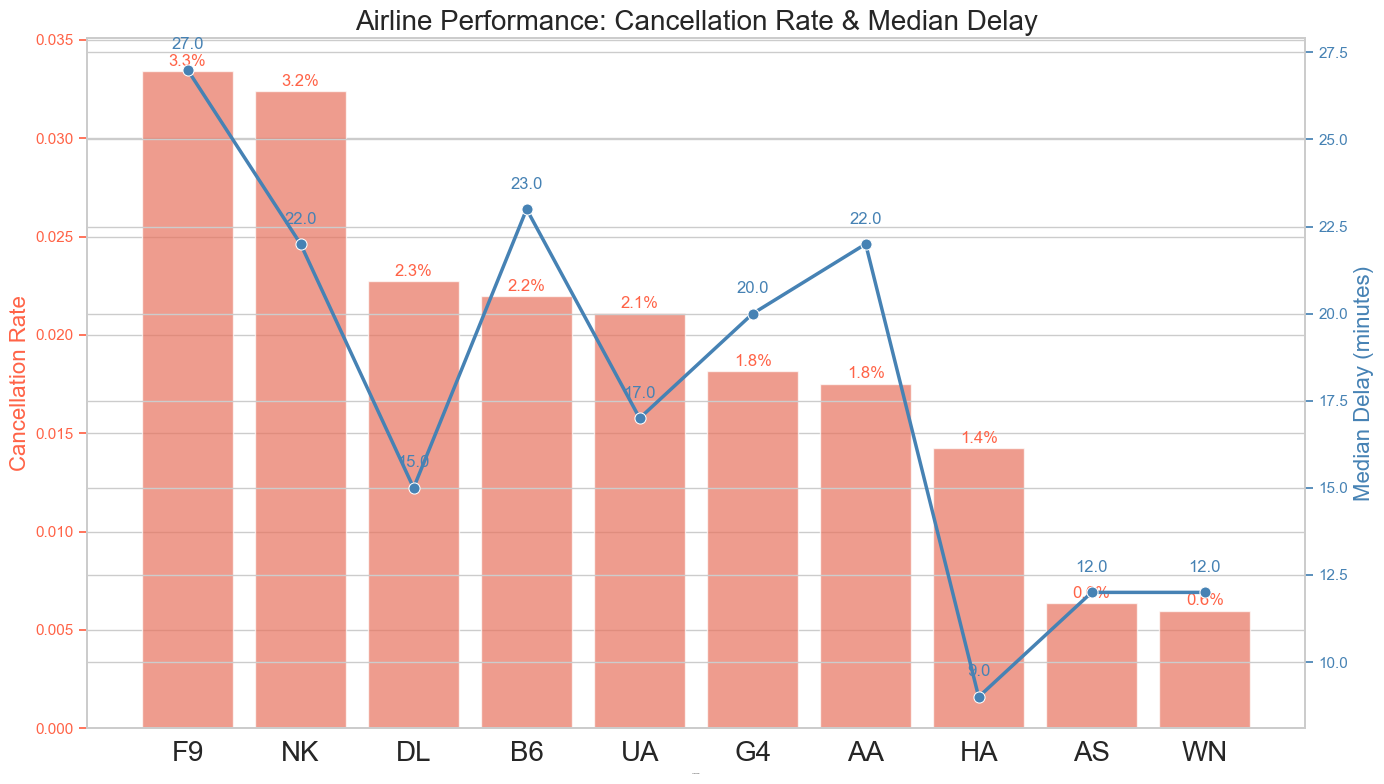

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# 数据准备
airline_stats = df.groupby('MKT_AIRLINE').agg(
    cancellation_rate=('CANCELLED', 'mean'),
    median_delay=('DEP_DELAY', lambda x: x[x >= 0].median())  # 仅统计未取消航班的延误
).reset_index().sort_values('cancellation_rate', ascending=False)

# 创建画布和双轴
fig, ax1 = plt.subplots(figsize=(14, 8))

# 条形图：取消率（主Y轴）
sns.barplot(
    data=airline_stats,
    x='MKT_AIRLINE',
    y='cancellation_rate',
    color='tomato',
    alpha=0.7,
    ax=ax1
)
ax1.set_title("Airline Performance: Cancellation Rate & Median Delay", fontsize=20)
ax1.set_xlabel("Airline Code", fontsize=0)
ax1.set_ylabel("Cancellation Rate", color='tomato', fontsize=16)
ax1.tick_params(axis='y', colors='tomato')
plt.xticks(rotation=0, fontsize = 20)

# 折线图：延误中位数（次Y轴）
ax2 = ax1.twinx()
sns.lineplot(
    data=airline_stats,
    x='MKT_AIRLINE',
    y='median_delay',
    color='steelblue',
    marker='o',
    linewidth=2.5,
    markersize=8,
    ax=ax2
)
ax2.set_ylabel("Median Delay (minutes)", color='steelblue', fontsize=16)
ax2.tick_params(axis='y', colors='steelblue')

# 添加数据标签
for p in ax1.patches:
    ax1.annotate(
        f"{p.get_height():.1%}", 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(0, 7), 
        textcoords='offset points',
        color='tomato'
    )

for x, y in zip(range(len(airline_stats)), airline_stats['median_delay']):
    ax2.text(
        x, y+0.5, 
        f"{y:.1f}", 
        ha='center', va='bottom',
        color='steelblue'
    )

# 优化布局
plt.tight_layout()
plt.show()